In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip3 install pickle5
import pickle5 as pickle
!pip3 install --upgrade pandas==1.3.4
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
!pip3 install torchviz
from torchviz import make_dot

from google.colab import drive
drive.mount('/content/drive')

!ls drive/'My Drive'

drive_path = 'drive/My Drive/'
drive_path = 'drive/MyDrive/Deep Learning/Lira'

     |████████████████████████████████| 256 kB 6.1 MB/s 
     |████████████████████████████████| 11.3 MB 4.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=c70314c3752b4cd5f35b38764bbe9935801c03e887dc8eb0e15fe0d6c1bf68e6
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
with open(drive_path+'/dataset_big_boi_no_split_no_shuffle.pickle', 'rb') as f:
    data_org = pickle.load(f)

In [ ]:

# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# train_dataset = moving_average(data['GM.acc.xyz.z'][8],10)

# test_dataset = moving_average(data['GM.acc.xyz.z'][1615],10)

train_dataset = [[],[]]
test_dataset = [[],[]]
iri_mean = []
data = data_org
data = data.sort_values(by=['IRI_mean'])

for i in range(int(len(data['IRI_Sequence']))):
    mean = np.mean(data['IRI_Sequence'].iloc[i])
    iri_mean.append(mean)
    if mean <5:
        train_dataset[0].append(mean)
        train_dataset[1].append(data['z_smooth'].iloc[i])
    elif mean > 5:
        test_dataset[0].append(mean)
        test_dataset[1].append(data['z_smooth'].iloc[i])


print(len(train_dataset[0]))
print(len(test_dataset[0]))
# Add good roads to test set
for i in range(100):
  test_dataset[0].append(train_dataset[0][i])
  test_dataset[1].append(train_dataset[1][i])

print(len(train_dataset[0]))
print(len(test_dataset[0]))

train_dataset[0] =  train_dataset[0][100:]
train_dataset[1] =  train_dataset[1][100:]
train_np = np.asarray(train_dataset,dtype=object).T
test_np = np.asarray(test_dataset,dtype=object).T
train_dataset_prep = train_dataset
test_dataset_prep = test_dataset
df_train = pd.DataFrame(np.asarray(train_dataset,dtype=object).T,columns=['iri','z'])
df_test = pd.DataFrame(np.asarray(test_dataset,dtype=object).T,columns=['iri','z'])

num_batches_train = len(df_train)

2696
362
2696
462


In [ ]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

print('train dataset',train_np.shape)
lstm_df_train = pd.DataFrame([np.append(*row) for row in train_np])
# lstm_df_train = lstm_df_train.drop(lstm_df_train.columns[1], axis=1)
lstm_df_train = lstm_df_train.loc[:,1:]
# lstm_df_train = lstm_df_train.loc[:,1:]
print(lstm_df_train.shape)
train_dataset, seq_len, n_features = create_dataset(lstm_df_train)
print('test dataset',test_np.shape)
lstm_df_test = pd.DataFrame([np.append(*row) for row in test_np])
# lstm_df_test = lstm_df_test.drop(lstm_df_test.columns[1], axis=1)
lstm_df_test = lstm_df_test.loc[:,1:]
# lstm_df_test = lstm_df_test.loc[:,1:]
print(lstm_df_test.shape)
test_dataset, seq_len_test, n_features_test = create_dataset(lstm_df_test)



train dataset (2596, 2)
(2596, 3065)
test dataset (462, 2)
(462, 3065)


In [ ]:
print(test_dataset_prep[1][0])
print(test_dataset[0])
print(test_dataset_prep[0][0])

[1.02152481 1.01966767 1.01818196 ... 1.01262857 1.01411429 1.0156    ]
tensor([[1.0215],
        [1.0197],
        [1.0182],
        ...,
        [1.0126],
        [1.0141],
        [1.0156]])
5.0067290589


In [ ]:
# working model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# working model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.seq_len = seq_len

        self.l_1 = nn.Linear(in_features=766,
                            out_features=650,
                            bias=False)
        self.lstm = nn.LSTM(650, 650, 1, bidirectional  = False ,batch_first = True)
        self.l_2 = nn.Linear(in_features=650,
                            out_features=766,
                            bias=False)
        
        self.relu = torch.nn.ReLU()   
        
    def forward(self, x):

        x = self.l_1(x)
        x = self.relu(x)
        x, (h, _) = self.lstm(x)
        x = self.relu(h)
        x = self.l_2(x)
        
        return x



model = Autoencoder()

model = model.to(device)
print(model)


In [ ]:
# LSTM all 100m
def train_model(model, train_dataset, n_epochs):
  model_out = np.asarray([])
  model_in = np.asarray([])
  recon_loss_train = []
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  #criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])


  model_test_out = np.asarray([])
  model_test_in = np.asarray([])
  recon_loss_test = []
  seq_count = 0

  for epoch in range(1, n_epochs + 1):
    i = 0
    model = model.train()
    train_losses = []
    test_losses = []
    batch_loss = []
    for seq_true in train_dataset:
      batch_size = 771
      no_batches = int(len(seq_true)/batch_size)
      for bt in range(no_batches):
        seq = seq_true[bt*batch_size:(bt+1)*batch_size]
        optimizer.zero_grad()
        seq = seq.to(device)
        seq = seq.reshape((1, batch_size, 1))
        seq_pred = model(seq)
        loss = criterion(seq_pred, seq)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch == n_epochs:
          model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(batch_size,))))
          batch_loss.append(loss.item())
      if epoch == n_epochs:
        model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
        recon_loss_train.append(batch_loss[-1])
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')

    batch_test_loss = []
    for seq_true in test_dataset:
      batch_size = 771
      no_batches = int(len(seq_true)/batch_size)
      for bt in range(no_batches):
        seq = seq_true[bt*batch_size:(bt+1)*batch_size]
        seq = seq.to(device)
        seq = seq.reshape((1, batch_size, 1))
        seq_pred = model(seq)
        loss = criterion(seq_pred, seq)
        batch_test_loss.append(loss.item())
        test_losses.append(loss.item())
        if epoch == n_epochs:
          model_test_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(batch_size,))))
          batch_test_loss.append(loss.item())
      if epoch == n_epochs:
        model_test_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
        recon_loss_test.append(batch_test_loss[-1])
      test_loss = np.mean(test_losses)
      history['val'].append(test_loss)
      seq_count +=1
      print(f'Seq {seq_count}: test loss {test_loss}')

    i+=1

  return model.eval(), history, model_out, model_in, recon_loss_train

model, history, model_out, model_in, recon_loss_train = train_model(
  model,
  train_dataset,
  n_epochs=5
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 771, 1])) that is different to the input size (torch.Size([771, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 0.0031339274711571683
Seq 1: test loss 5.653273092320887e-06
Seq 2: test loss 4.1270238853030605e-06
Seq 3: test loss 4.258397262270188e-06
Seq 4: test loss 4.385994846719162e-06
Seq 5: test loss 4.3590383938862946e-06
Seq 6: test loss 4.019801874872226e-06
Seq 7: test loss 3.933926493681654e-06
Seq 8: test loss 4.042849700643576e-06
Seq 9: test loss 5.176385983489766e-06
Seq 10: test loss 5.424210420793921e-06
Seq 11: test loss 5.824154258830689e-06
Seq 12: test loss 5.596048882555098e-06
Seq 13: test loss 5.320103917792716e-06
Seq 14: test loss 5.50575355245677e-06
Seq 15: test loss 5.406115418635535e-06
Seq 16: test loss 5.606166451362545e-06
Seq 17: test loss 6.257906991278087e-06
Seq 18: test loss 6.060628232228703e-06
Seq 19: test loss 7.0265706805609325e-06
Seq 20: test loss 6.932415741781976e-06
Seq 21: test loss 6.859765856836656e-06
Seq 22: test loss 6.721682082529283e-06
Seq 23: test loss 7.067466592583304e-06
Seq 24: test loss 7.265278568979738e-06
Seq 2

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 3065, 1])) that is different to the input size (torch.Size([3065, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 1.279131531715393
Epoch 2: train loss 1.2755882740020752
Epoch 3: train loss 1.271979808807373
Epoch 4: train loss 1.268256425857544
Epoch 5: train loss 1.2643712759017944
Epoch 6: train loss 1.2602710723876953
Epoch 7: train loss 1.2558976411819458
Epoch 8: train loss 1.2511881589889526
Epoch 9: train loss 1.2460741996765137
Epoch 10: train loss 1.240479588508606
Epoch 11: train loss 1.2343209981918335
Epoch 12: train loss 1.2275052070617676
Epoch 13: train loss 1.219929814338684
Epoch 14: train loss 1.2114814519882202
Epoch 15: train loss 1.2020343542099
Epoch 16: train loss 1.1914479732513428
Epoch 17: train loss 1.1795642375946045
Epoch 18: train loss 1.1662043333053589
Epoch 19: train loss 1.151166558265686
Epoch 20: train loss 1.1342228651046753
Epoch 21: train loss 1.1151165962219238
Epoch 22: train loss 1.0935615301132202
Epoch 23: train loss 1.069239854812622
Epoch 24: train loss 1.0418050289154053
Epoch 25: train loss 1.0108882188796997
Epoch 26: train los

Text(0.5, 1.0, 'LSTM Autoencoder')

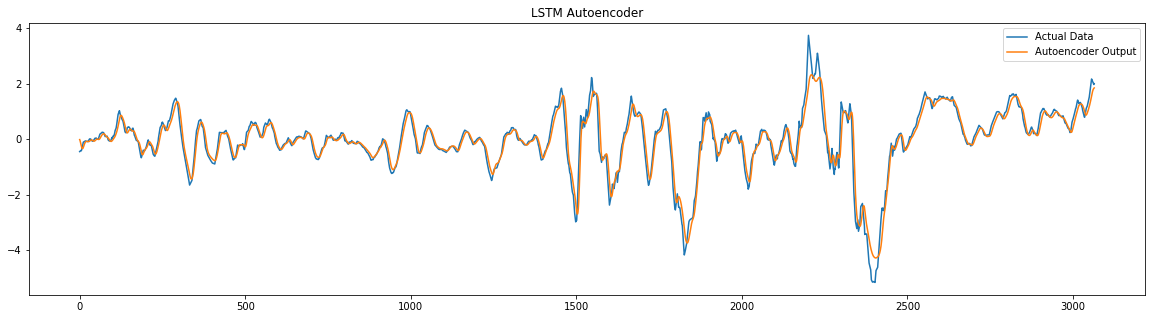

In [ ]:
# LSTM 100m
        
def train_model(model, train_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  best_loss = 10000.0
  output = []
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []      
    optimizer.zero_grad()
    seq_true = torch.Tensor(train_np[0,1]).cuda()
    seq_true = seq_true.to(device)
    seq_true = seq_true.reshape((1, seq_len, 1))
    seq_pred = model(seq_true)
    loss = criterion(seq_pred, seq_true)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
    if(epoch == n_epochs):
      output.append(seq_pred.cpu().detach().numpy())
  return model.eval(), history, output

model, history, pred = train_model(
  model,
  train_dataset,
  n_epochs=100
)


plt.figure(figsize=[20,5])
plt.plot(train_np[0,1][:])
plt.plot(pred[0])
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

In [ ]:
path = drive_path + f'/Lira_batch_val.pth'
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 771, 1])) that is different to the input size (torch.Size([771, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 0.0037266473203590436
Epoch 2: train loss 5.8327418039571e-06


Text(0.5, 1.0, 'LSTM Autoencoder')

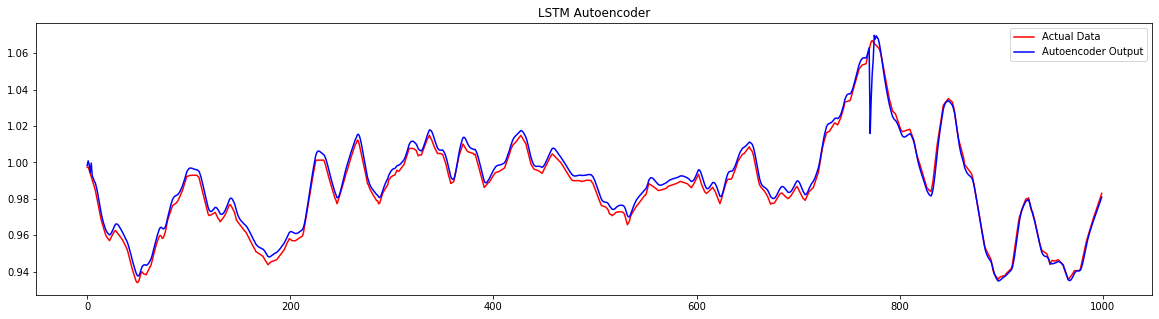

In [ ]:
# LSTM all 100m
def train_model(model, train_dataset, n_epochs):
  model_out = np.asarray([])
  model_in = np.asarray([])
  recon_loss_train = []
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  #criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    i = 0
    model = model.train()
    train_losses = []
    batch_loss = []
    for seq_true in train_dataset:
      batch_size = 771
      no_batches = int(len(seq_true)/batch_size)
      for bt in range(no_batches):
        seq = seq_true[bt*batch_size:(bt+1)*batch_size]
        optimizer.zero_grad()
        seq = seq.to(device)
        seq = seq.reshape((1, batch_size, 1))
        seq_pred = model(seq)
        loss = criterion(seq_pred, seq)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch == n_epochs:
          model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(batch_size,))))
          batch_loss.append(loss.item())
      if epoch == n_epochs:
        model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
        recon_loss_train.append(batch_loss[-1])
      i+=1
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
  return model.eval(), history, model_out, model_in, recon_loss_train

model, history, model_out, model_in, recon_loss_train = train_model(
  model,
  train_dataset,
  n_epochs=5
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

Text(0.5, 1.0, 'LSTM Autoencoder')

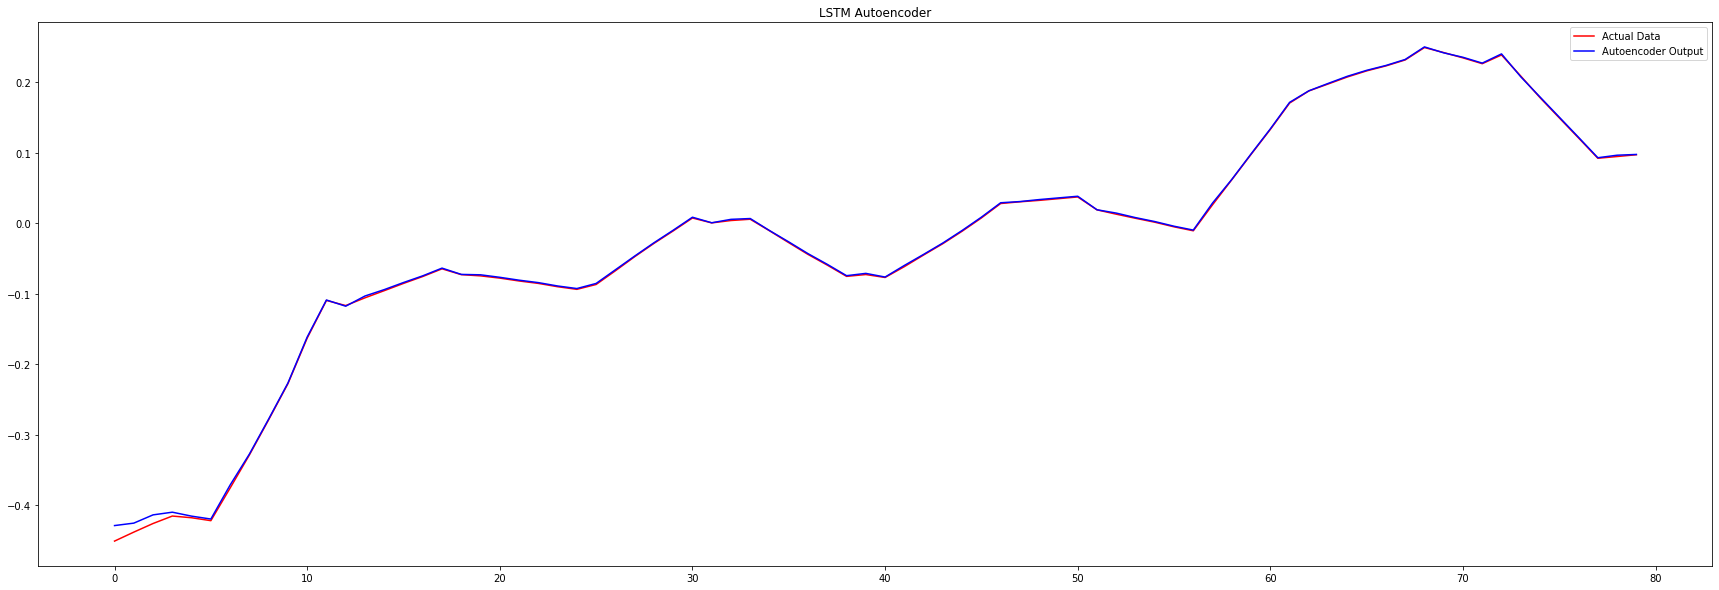

In [ ]:
plt.figure(figsize=[30,10])
plt.plot(model_in[:80],'r')
plt.plot(model_out[:80],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

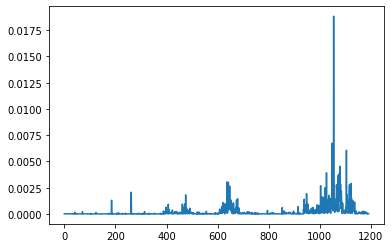

In [ ]:
plt.figure()
plt.plot(recon_loss_train)

In [ ]:
path = drive_path + f'/Lira_with_batch.pth'
torch.save(model.state_dict(), path)

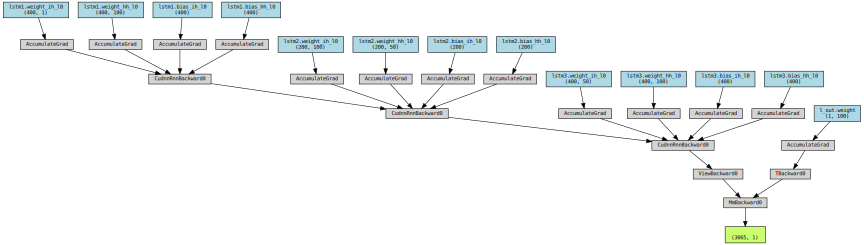

In [ ]:
seq_true = train_dataset[1]
seq_true = seq_true.to(device)
seq_true = seq_true.reshape((1, seq_len, 1))
seq_pred = model(seq_true)
make_dot(model(seq_true),params=dict(model.named_parameters()))


1.0520929208723828e-05


Text(0.5, 1.0, 'LSTM Autoencoder - Test')

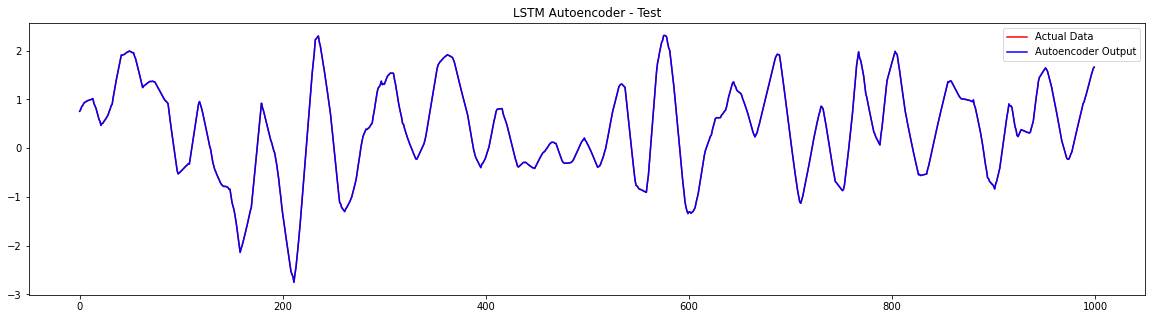

In [ ]:
# Test Dataset
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

seq_true = test_dataset[-1]
seq_true = seq_true.to(device)
seq_true1 = seq_true.reshape((1, seq_len, 1))
seq_pred = model(seq_true1)
loss = criterion(seq_pred, seq_true)
print(loss.item())

plt.figure(figsize=(20,5))
plt.plot(seq_true.cpu()[:1000],'r')
plt.plot(seq_pred.cpu().detach().numpy()[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder - Test')

Text(0.5, 1.0, 'LSTM Autoencoder - Test')

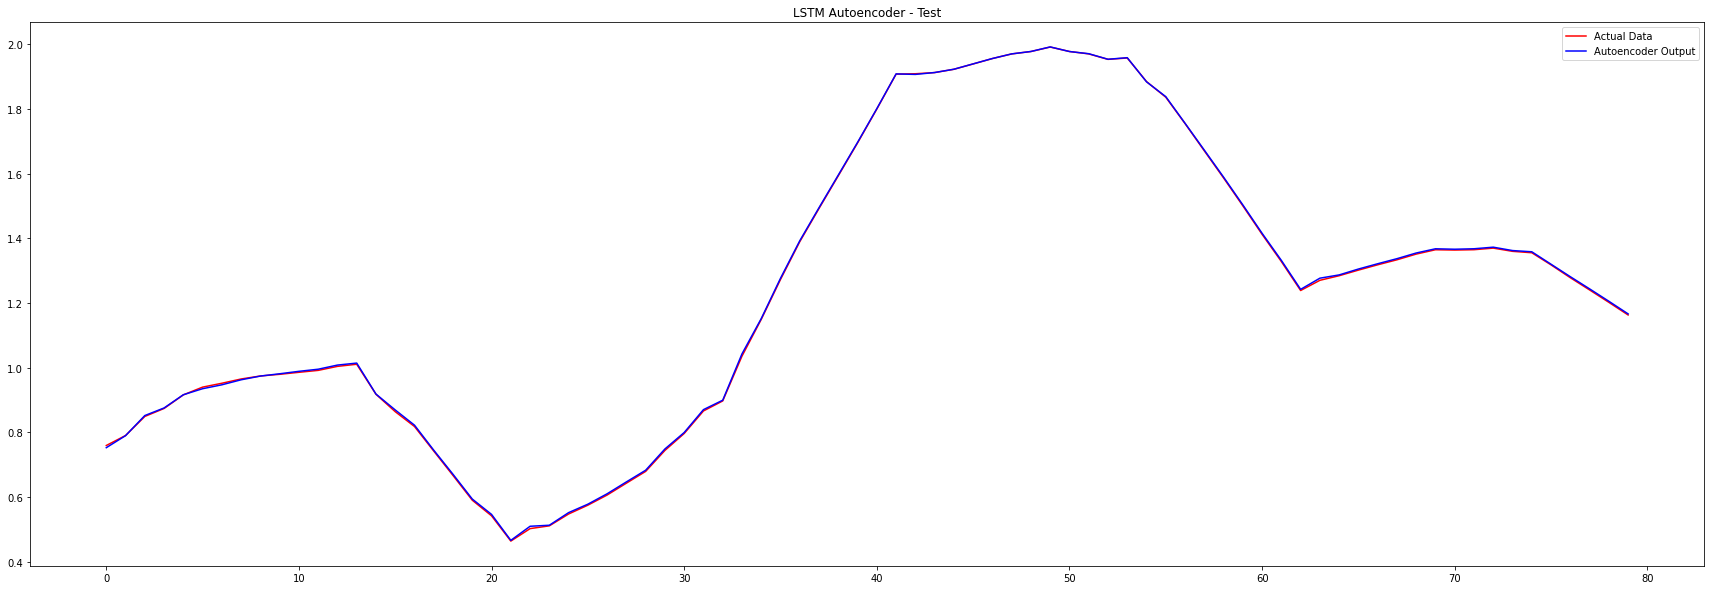

In [ ]:

plt.figure(figsize=(30,10))
plt.plot(seq_true.cpu()[:80],'r')
plt.plot(seq_pred.cpu().detach().numpy()[:80],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder - Test')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 771, 1])) that is different to the input size (torch.Size([771, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Seq 1: test loss 3.4295628665859113e-06
Seq 2: test loss 2.941846560133854e-06
Seq 3: test loss 2.6265199721819954e-06
Seq 4: test loss 2.4415819552814355e-06
Seq 5: test loss 2.313790218977374e-06
Seq 6: test loss 2.428459993097931e-06
Seq 7: test loss 2.417751829852932e-06
Seq 8: test loss 2.19629555431311e-06
Seq 9: test loss 2.5846568405540893e-06
Seq 10: test loss 2.625916522447369e-06
Seq 11: test loss 4.210974566376535e-06
Seq 12: test loss 2.413548827462364e-06
Seq 13: test loss 2.4492517241014866e-06
Seq 14: test loss 2.520165025998722e-06
Seq 15: test loss 2.75664228865935e-06
Seq 16: test loss 2.590423719084356e-06
Seq 17: test loss 2.634865040818113e-06
Seq 18: test loss 2.531407744754688e-06
Seq 19: test loss 3.3249750686081825e-06
Seq 20: test loss 2.2353367512550903e-06
Seq 21: test loss 2.293120360263856e-06
Seq 22: test loss 2.4350608782697236e-06
Seq 23: test loss 2.4189209852920612e-06
Seq 24: test loss 1.0996807759511285e-05
Seq 25: test loss 6.348923307086807e-06
S

Text(0.5, 1.0, 'LSTM Autoencoder')

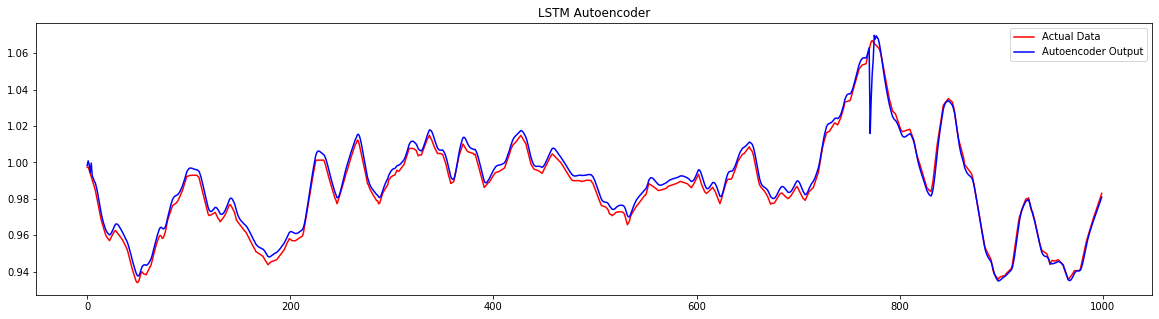

In [ ]:
def test_model(model, test_dataset):
  model_out = np.asarray([])
  model_in = np.asarray([])
  recon_loss_test = []
  criterion = nn.MSELoss()
  history = dict(test=[], val=[])
  test_losses = []
  seq_count = 0
  for seq_true in test_dataset:
    seq_true = seq_true.to(device)
    batch_size = 771
    no_batches = int(len(seq_true)/batch_size)
    batch_loss=[]
    for bt in range(no_batches):
      seq = seq_true[bt*batch_size:(bt+1)*batch_size]
      seq = seq.to(device)
      seq = seq.reshape((1, batch_size, 1))
      seq_pred = model(seq)
      loss = criterion(seq_pred, seq)
      test_losses.append(loss.item())
      model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(batch_size,))))
      batch_loss.append(loss.item())
    model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
    recon_loss_test.append(batch_loss[-1]/no_batches)    
    history['test'].append(test_losses)
    seq_count +=1
    print(f'Seq {seq_count}: test loss {loss.item()}')
  return model.eval(), history, model_out, model_in, recon_loss_test


# lstm_df_train = lstm_df_train.loc[40:,1:]
# test_dataset1, seq_len, n_features = create_dataset(lstm_df_train)

# print(len(test_dataset))
# test_datase_final = [*test_dataset, *test_dataset1]
# print(len(test_datase_final))

model_test, history_test, model_out_test, model_in_test, recon_loss_test = test_model(
  model,
  test_dataset
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

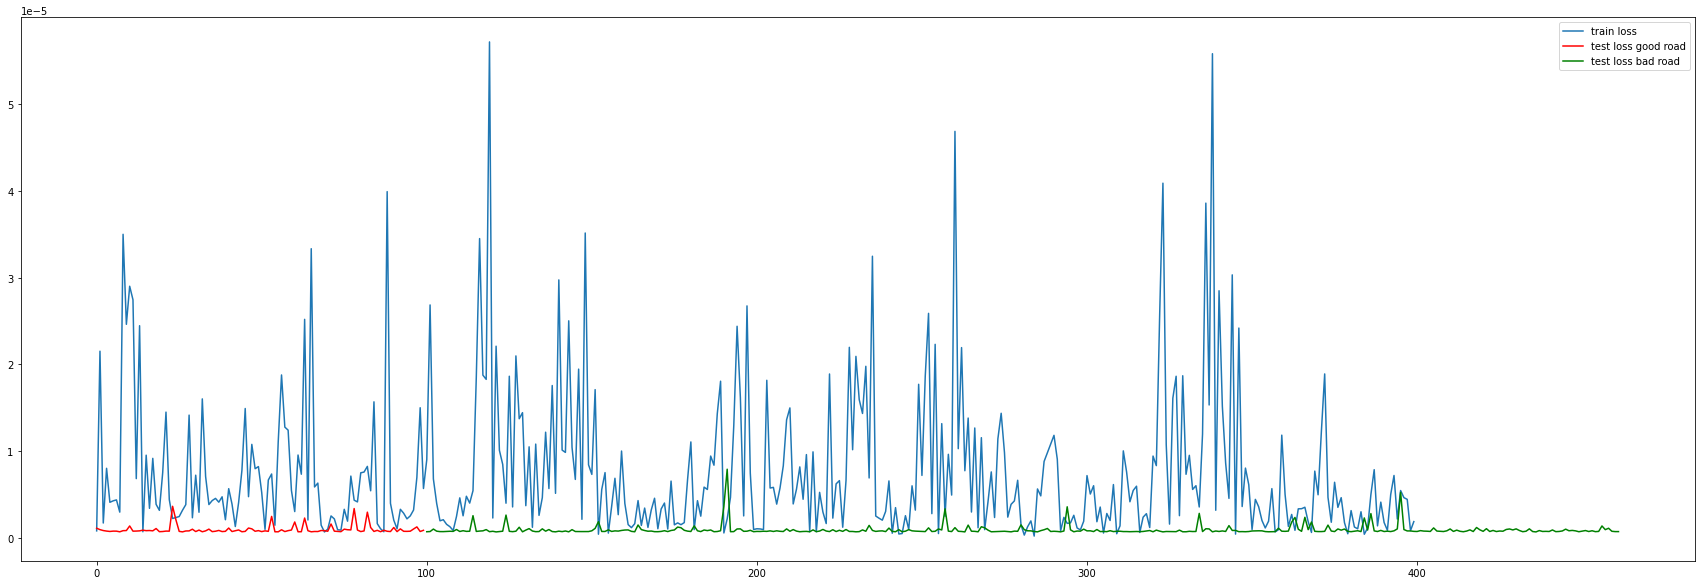

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(recon_loss_train[:400])
plt.plot(recon_loss_test[:100],'r')
plt.plot(range(100,462),recon_loss_test[100:],'g')
plt.legend(['train loss','test loss good road','test loss bad road'])

In [ ]:
net_batch = Autoencoder()
path = drive_path + f'/Lira_final_big.pth'
net_batch.load_state_dict(torch.load(path))
net_batch = net_batch.to(device)
net_batch.eval()

Autoencoder(
  (lstm1): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (lstm3): LSTM(50, 100, batch_first=True)
  (l_out): Linear(in_features=100, out_features=1, bias=False)
)

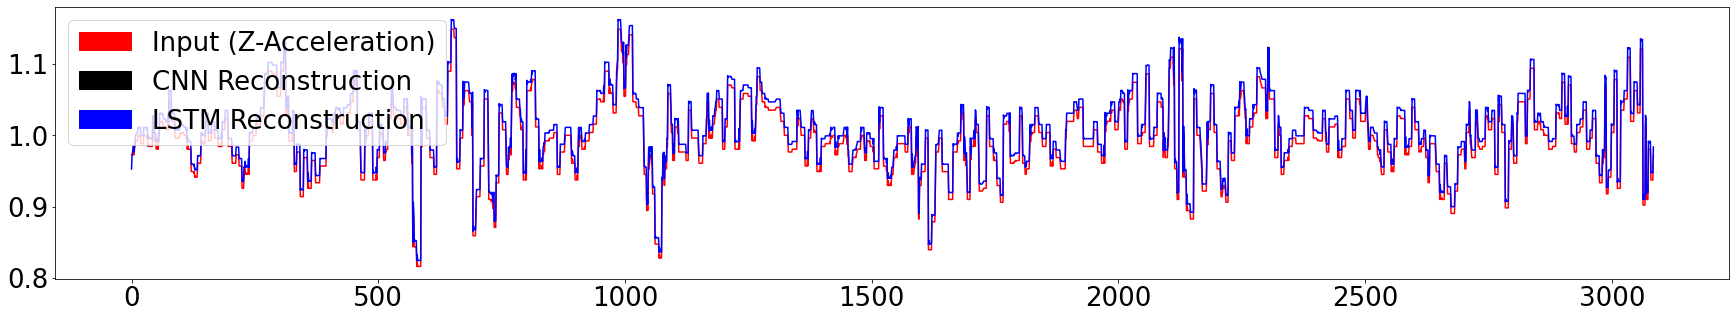

In [ ]:
seq = torch.from_numpy(np.asarray(data_org['z'][0])).float()
seq = seq.cuda()
seq = seq.reshape((1, 3085, 1))
seq_pred = net_batch(seq)

import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

plt.figure(figsize=[30,5])
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)
plt.plot(data_org['z'][0],'r')
plt.plot(seq_pred.cpu().detach().numpy(),'b')
input = mpatches.Patch(color=colors["r"], label='Input (Z-Acceleration)')
cnn = mpatches.Patch(color=colors["k"], label="CNN Reconstruction")
lstm = mpatches.Patch(color=colors["b"], label="LSTM Reconstruction")
plt.legend(handles=[input,cnn,lstm],fontsize=26,loc='upper left')
# plt.legend(['input','autoencoder'],fontsize=20,loc='upper left')
# plt.legend(fontsize=20,loc="upper left")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 771, 1])) that is different to the input size (torch.Size([771, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Seq 100: train loss 0.00012283391455033174
Seq 200: train loss 0.00011936221320259695
Seq 300: train loss 0.00012119822107100238
Seq 400: train loss 0.00012245625597036755
Seq 500: train loss 0.00012200963343881692
Seq 600: train loss 0.0001225691448780708
Seq 700: train loss 0.00012036038727577154
Seq 800: train loss 0.00012380156355599561
Seq 900: train loss 0.00012176130500544484
Seq 1000: train loss 0.00011803264351328835
Seq 1100: train loss 0.0001216658662694196
Seq 1200: train loss 0.00011952378069205831
Seq 1300: train loss 0.00011873339341642956
Seq 1400: train loss 0.0001227646935149096
Seq 1500: train loss 0.00012197408068459481
Seq 1600: train loss 0.00012180743215139955
Seq 1700: train loss 0.00012033767173610006
Seq 1800: train loss 0.00012067581944090004
Seq 1900: train loss 0.00012094986838443826
Seq 2000: train loss 0.00012126012249306466
Seq 2100: train loss 0.00012180818642567222
Seq 2200: train loss 0.0001205333416388991
Seq 2300: train loss 0.00012045233597746119
S

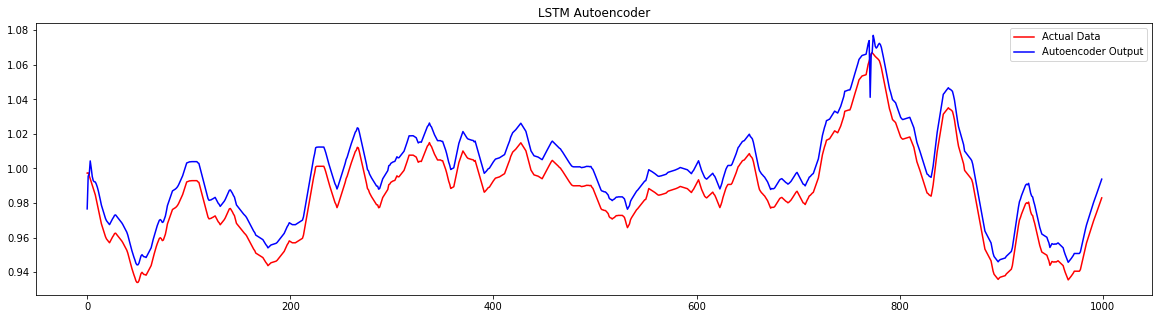

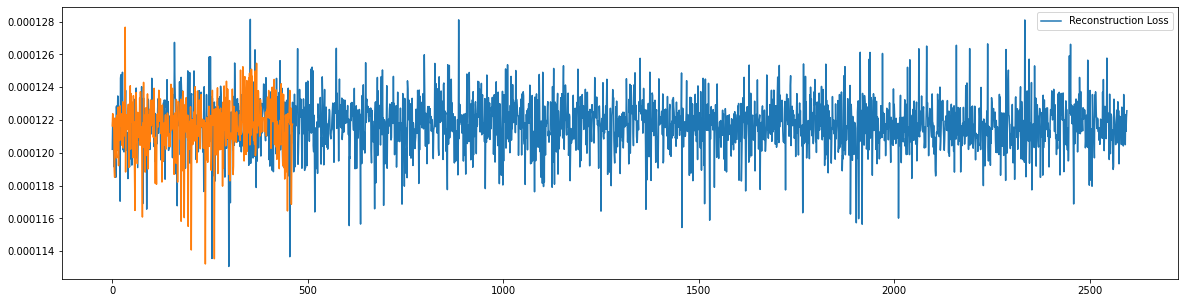

In [ ]:
def model_predict(model, train_dataset, test_dataset):
  model_out = np.asarray([])
  criterion = nn.MSELoss()
  model_in = np.asarray([])
  recon_loss_train = []
  history = dict(train=[], val=[])
  seq_c = 0
  for seq_true in train_dataset:
    batch_size = 771
    batch_loss = []
    no_batches = int(len(seq_true)/batch_size)
    for bt in range(no_batches):
      seq = seq_true[bt*batch_size:(bt+1)*batch_size]
      seq = seq.to(device)
      seq = seq.reshape((1, batch_size, 1))
      seq_pred = model(seq)
      loss = criterion(seq_pred, seq)
      model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(batch_size,))))
      batch_loss.append(loss.item())
    model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
    recon_loss_train.append(np.mean(batch_loss))
    train_loss = np.mean(batch_loss)
    history['train'].append(train_loss)
    seq_c +=1
    if (seq_c%100 ==0):
      print(f'Seq {seq_c}: train loss {train_loss}')

  print('Test')
  model_out_test = np.asarray([])
  model_in_test = np.asarray([])
  recon_loss_test = []
  seq_c = 0
  for seq_true in test_dataset:
    batch_size = 771
    batch_loss_test = []
    no_batches = int(len(seq_true)/batch_size)
    for bt in range(no_batches):
      seq = seq_true[bt*batch_size:(bt+1)*batch_size]
      seq = seq.to(device)
      seq = seq.reshape((1, batch_size, 1))
      seq_pred = model(seq)
      loss = criterion(seq_pred, seq)
      model_out_test = np.concatenate((model_out_test,np.reshape(seq_pred.cpu().detach().numpy(),(batch_size,))))
      batch_loss_test.append(loss.item())
    model_in_test=np.concatenate((model_in_test,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
    recon_loss_test.append(np.mean(batch_loss_test))
    test_loss = np.mean(batch_loss_test)
    history['val'].append(batch_loss_test)
    seq_c +=1
    if (seq_c%100 ==0):
      print(f'Seq {seq_c}: test loss {test_loss}')
  return model.eval(), history, model_out, model_in, recon_loss_train, recon_loss_test, model_in_test, model_out_test

net_batch, history, model_out, model_in, recon_loss_train,recon_loss_test, model_in_test, model_out_test = model_predict(
  net_batch,
  train_dataset,
  test_dataset
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

plt.figure(figsize=[20,5])
plt.plot(recon_loss_train)
plt.plot(recon_loss_test)
plt.legend(['Reconstruction Loss'])

Seq 100: train loss 0.801302969455719
Seq 200: train loss 0.8090603351593018
Seq 300: train loss 0.8060266375541687
Seq 400: train loss 0.8233417272567749
Seq 500: train loss 0.8202902674674988
Seq 600: train loss 0.8117480278015137
Seq 700: train loss 0.7966632843017578
Seq 800: train loss 0.8172909021377563
Seq 900: train loss 0.7902822494506836
Seq 1000: train loss 0.8029515147209167
Seq 1100: train loss 0.8133829832077026
Seq 1200: train loss 0.8106120228767395
Seq 1300: train loss 0.7878865003585815
Seq 1400: train loss 0.817327618598938
Seq 1500: train loss 0.8067166209220886
Seq 1600: train loss 0.8118512630462646
Seq 1700: train loss 0.8005772233009338
Seq 1800: train loss 0.8195234537124634
Seq 1900: train loss 0.8054233193397522
Seq 2000: train loss 0.8112558126449585
Seq 2100: train loss 0.8151100873947144
Seq 2200: train loss 0.8095285892486572
Seq 2300: train loss 0.7861080169677734
Seq 2400: train loss 0.803534746170044
Seq 2500: train loss 0.7963008284568787
Test
Seq 100

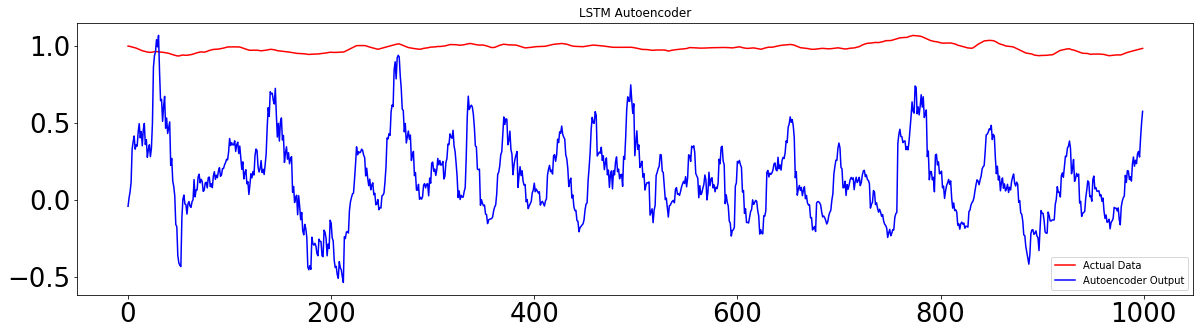

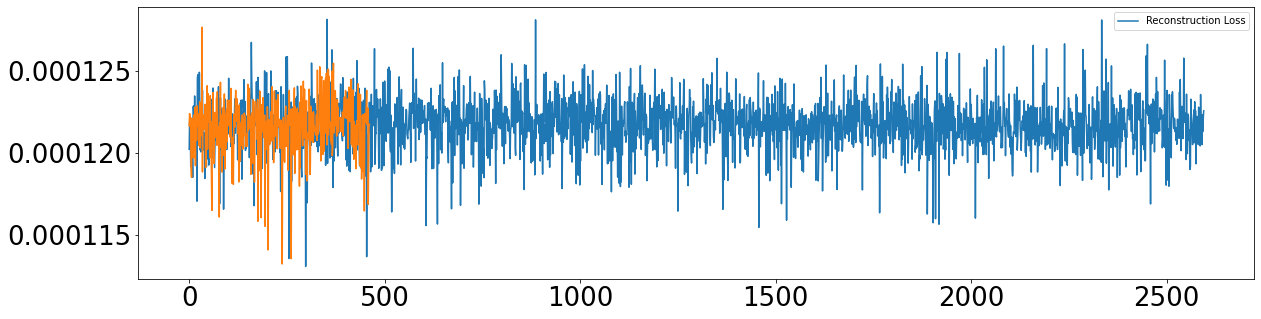

In [ ]:
def model_predict(model, train_dataset, test_dataset):
  model_out = np.asarray([])
  criterion = nn.MSELoss()
  model_in = np.asarray([])
  recon_loss_train = []
  history = dict(train=[], val=[])
  seq_c = 0
  batch_loss =[]
  for seq_true in train_dataset:
    seq = seq_true
    seq = seq.to(device)
    seq = seq.reshape((1, 1,seq_len))
    seq_pred = model(seq)
    loss = criterion(seq_pred, seq)
    model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(seq_len,))))
    batch_loss.append(loss.item())
    model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
    recon_loss_train.append(loss.item())
    train_loss = loss.item()
    history['train'].append(loss.item())
    seq_c +=1
    if (seq_c%100 ==0):
      print(f'Seq {seq_c}: train loss {train_loss}')

  print('Test')
  model_out_test = np.asarray([])
  model_in_test = np.asarray([])
  recon_loss_test = []
  seq_c = 0
  batch_loss_test =[]
  for seq_true in test_dataset:
    seq = seq_true
    seq = seq.to(device)
    seq = seq.reshape((1, 1,seq_len))
    seq_pred = model(seq)
    loss = criterion(seq_pred, seq)
    model_out_test = np.concatenate((model_out_test,np.reshape(seq_pred.cpu().detach().numpy(),(seq_len,))))
    batch_loss_test.append(loss.item())
    model_in_test=np.concatenate((model_in_test,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
    recon_loss_test.append(loss.item())
    test_loss = (loss.item())
    history['val'].append(loss.item())
    seq_c +=1
    if (seq_c%100 ==0):
      print(f'Seq {seq_c}: test loss {test_loss}')
  return model.eval(), history, model_out, model_in, recon_loss_train, recon_loss_test, model_in_test, model_out_test

net_batch, history, model_out, model_in, recon_loss_train_cnn,recon_loss_test_cnn, model_in_test, model_out_test = model_predict(
  model,
  train_dataset,
  test_dataset
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

plt.figure(figsize=[20,5])
plt.plot(recon_loss_train)
plt.plot(recon_loss_test)
plt.legend(['Reconstruction Loss'])

Text(0.5, 1.0, 'Reconstruction Loss')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


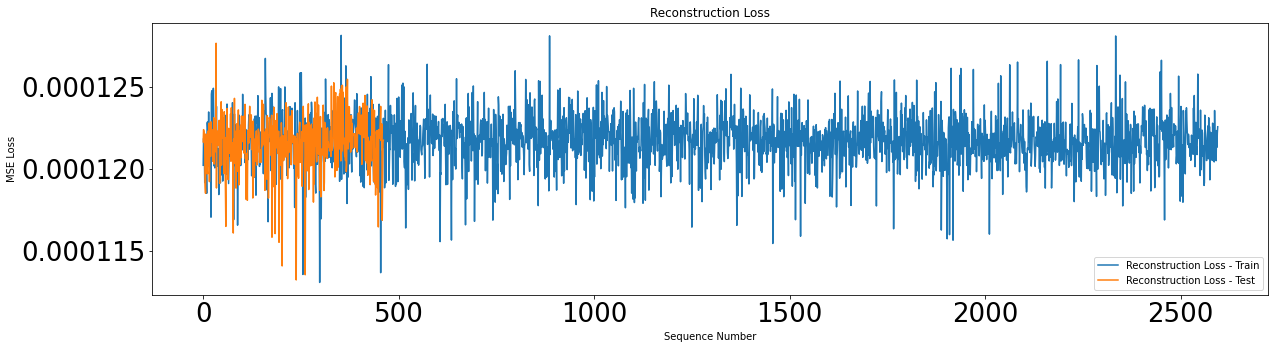

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


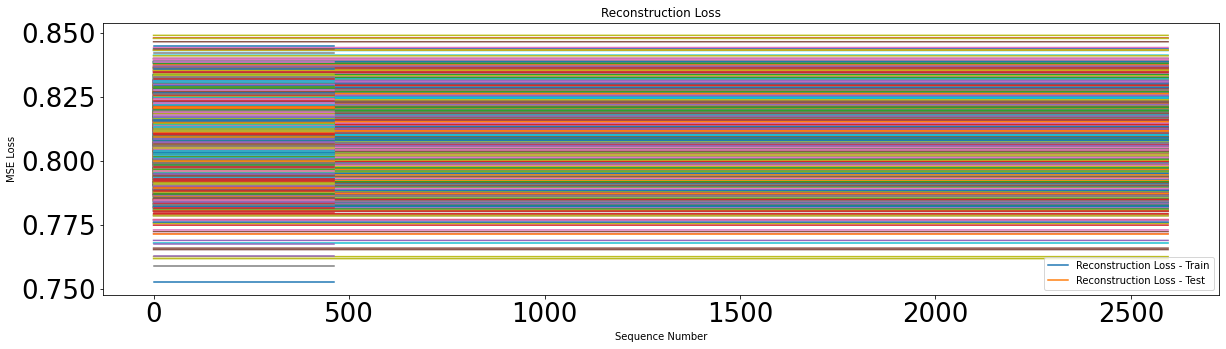

In [ ]:

plt.figure(figsize=[20,5])
plt.plot(recon_loss_train)
plt.plot(recon_loss_test)
plt.legend(['Reconstruction Loss - Train','Reconstruction Loss - Test'])
plt.xlabel('Sequence Number')
plt.ylabel('MSE Loss')
plt.title('Reconstruction Loss')


plt.figure(figsize=[20,5])
plt.plot(recon_loss_train_cnn)
plt.plot(recon_loss_test_cnn)
plt.legend(['Reconstruction Loss - Train','Reconstruction Loss - Test'])
plt.xlabel('Sequence Number')
plt.ylabel('MSE Loss')
plt.title('Reconstruction Loss')

In [ ]:
print((test_dataset[0]))
print((test_dataset_prep[1][0]))

tensor([[1.0215],
        [1.0197],
        [1.0182],
        ...,
        [1.0126],
        [1.0141],
        [1.0156]])
[1.02152481 1.01966767 1.01818196 ... 1.01262857 1.01411429 1.0156    ]


In [ ]:
print(len(train_dataset_prep[0]))
print(len(test_dataset_prep[0]))

2596


In [ ]:
class_good = np.zeros(len(recon_loss_train), dtype=int)
# class_bad = np.ones(len(recon_loss_test)
class_bad = np.concatenate((np.ones(len(recon_loss_test)-100, dtype=int),np.zeros(100, dtype=int)))
iri_train = train_dataset_prep[0][:]
iri_test = test_dataset_prep[0][:]

# print(len(iri),len(targets))

print(len(recon_loss_train),len(iri_train),len(class_good))
train_recon = np.stack((recon_loss_train,class_good,iri_train),axis=1)
df_train_recon = pd.DataFrame(train_recon,columns=['data','target','IRI'])
df_train_recon = df_train_recon.sample(frac=1).reset_index(drop=True)

iri = np.concatenate((df_train_recon['IRI'][:250],iri_test))
targets = np.concatenate((df_train_recon['target'][:250],class_bad))
data_loss = np.concatenate((df_train_recon['data'][:250],recon_loss_test))
# iri = ((iri_test))
# targets = ((class_bad))
# data_loss = ((recon_loss_test))
df_loss = np.stack((data_loss,targets,iri),axis=1)
df_loss = pd.DataFrame(df_loss,columns=['data','target','IRI'])
print(len(class_good))
print(len(class_bad))
print(len(df_loss))

2596 2596 2596
2596
462
712


         data  target       IRI
0    0.000122       0  3.243419
1    0.000123       0  3.258122
2    0.000120       0  2.276602
3    0.000121       0  3.412961
4    0.000121       0  3.984411
..        ...     ...       ...
707  0.000123       0  1.214027
708  0.000117       0  1.216757
709  0.000120       0  1.218010
710  0.000122       0  1.218586
711  0.000122       0  1.218586

[712 rows x 3 columns]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

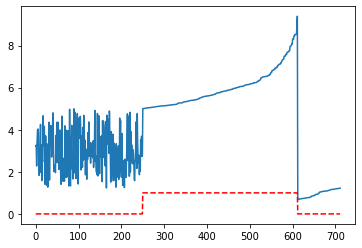

In [ ]:
df_loss['target'] = pd.to_numeric(df_loss['target'], downcast='integer')
print(df_loss)

print(class_bad,iri_test)

plt.figure()
plt.plot(df_loss['IRI'])
plt.plot(df_loss['target']*1,'r--')

In [ ]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear1 = torch.nn.Linear(1,30)
        self.linear2 = torch.nn.Linear(30,20)
        self.linear3 = torch.nn.Linear(20,1)
        self.relu = torch.nn.ReLU()   
        self.sm = torch.nn.Softmax()       
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(self.relu(x))
        return (self.sm(self.linear3(self.relu(x))))


LEARNING_RATE = 3e-4
criterion = nn.MSELoss()   #<-- Your code here.   

model_classifier = Classifier()
model_classifier = model_classifier
print(model_classifier)

Classifier(
  (linear1): Linear(in_features=1, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (sm): Softmax(dim=None)
)


In [ ]:
def train_model_classifier(model, train_dataset, n_epochs):
  model_out = []
  model_in = []
  recon_loss_train = []
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for i in range(len(train_dataset)):
      optimizer.zero_grad()
      seq_true = torch.from_numpy(np.asarray(train_dataset['data'][i])).float()
      seq_pred = model(seq_true.unsqueeze(dim=0))
      # loss = criterion(seq_pred, torch.from_numpy(np.asarray(train_dataset['target'][i])).float())
      loss = criterion(seq_pred, torch.from_numpy(np.asarray(train_dataset['target'][i])).float().reshape((1)))
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      if epoch == n_epochs:
        model_out.append(seq_pred.cpu().detach().numpy())
        model_in.append(train_dataset['target'][i])
        recon_loss_train.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
  return model.eval(), history, model_out, model_in, recon_loss_train

model_classifier, history_classifier, model_out_classifier, model_in_classifier, loss_train_classifier = train_model_classifier(
  model_classifier,
  df_loss_shuffle[:],
  n_epochs=20
)

plt.figure(figsize=[20,5])
plt.plot(model_in_classifier,'k--')
plt.plot(model_out_classifier,'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')



NameError: ignored

In [ ]:

df_loss_shuffle = df_loss.sample(frac=1).reset_index(drop=True)

Train
Linear SVM accuracy: 56.00%
[0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0
 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0
 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1
 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1
 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0
 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1
 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1
 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0]
[1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1
 1 1

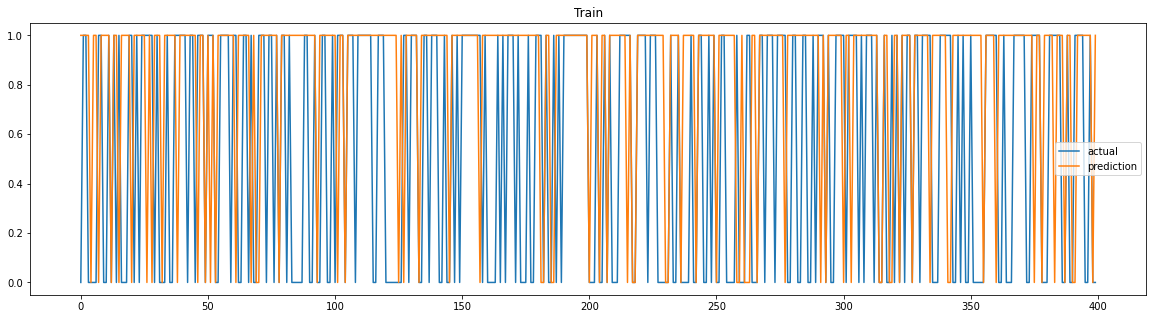

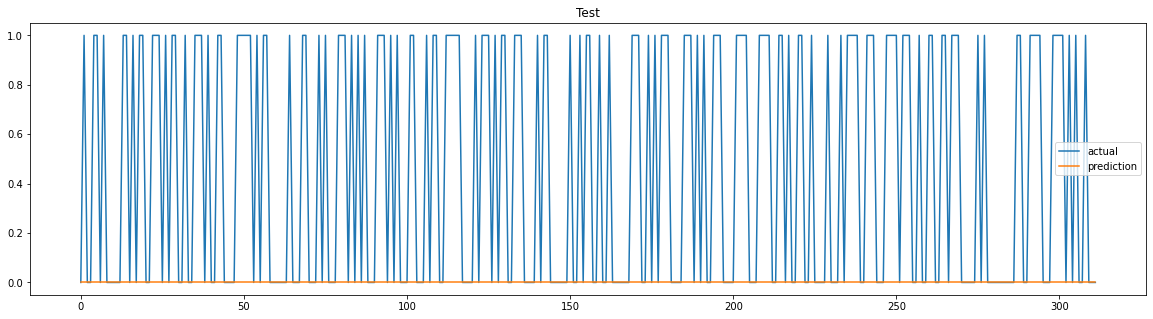

In [ ]:

from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
def fit_classifier(df_loss):
  limit = 400
  clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5,max_iter=1e5))
  X = np.array(df_loss['data'][:limit]).reshape(-1,1)
  y = df_loss['target'][:limit]
  clf.fit(X, y)
  score = clf.score(X, y)
  preds_train = clf.predict(X)
  print('Train')
  print(f"Linear SVM accuracy: {score*100:.2f}%")
  print(np.asarray(df_loss['target'][:limit]))
  print(preds_train)
  
  plt.figure(figsize=(20,5))
  plt.plot(np.asarray(df_loss['target'][:limit]))
  plt.plot(preds_train)
  plt.legend(['actual','prediction'])
  plt.title('Train')


  X_test = np.array(df_loss['data'][limit:]).reshape(-1,1)
  y_test = df_loss['target'][limit:]
  clf.fit(X_test, y_test)
  score_test = clf.score(X_test, y_test)
  preds_test = clf.predict(X_test)
  print('Test')
  print(f"Linear SVM accuracy: {score_test*100:.2f}%")
  print(np.asarray(df_loss['target'][limit:]))
  print(preds_test)
  
  plt.figure(figsize=(20,5))
  plt.plot(np.asarray(df_loss['target'][limit:]))
  plt.plot(preds_test)
  plt.legend(['actual','prediction'])
  plt.title('Test')

  preds = np.concatenate((preds_train,preds_test))
  preds = preds_train

  return score,preds

score, predictions = fit_classifier(df_loss_shuffle)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


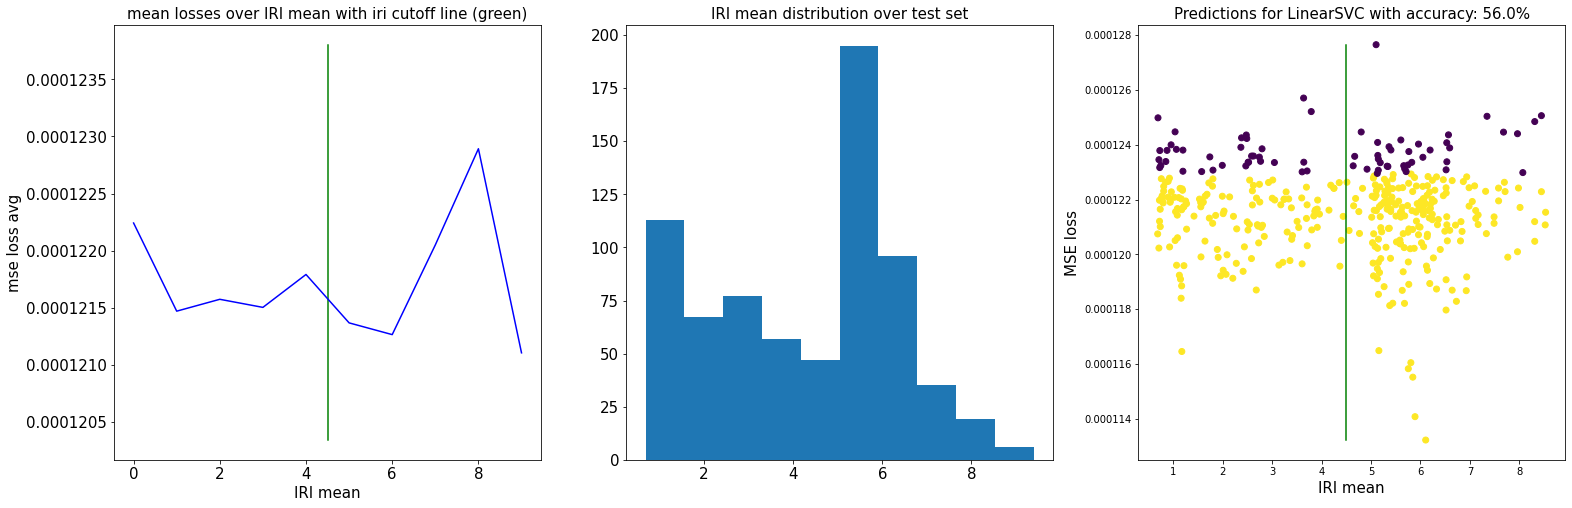

In [ ]:

limit = 400
mean_losses_100, mean_losses_10 = [],[]
for i in range(0,100,1):
  mean_losses_100.append(np.array(df_loss_shuffle['data'])[np.where((df_loss_shuffle['IRI']>i*0.1) & (df_loss_shuffle['IRI']<=i*0.1+0.1))[0]].mean())
for i in range(10):
  mean_losses_10.append(np.array(df_loss_shuffle['data'])[np.where((df_loss_shuffle['IRI']>i) & (df_loss_shuffle['IRI']<=i+1))[0]].mean())

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(26,8))
ax1.plot([4.5]*2,(np.nanmin(mean_losses_100),np.nanmax(mean_losses_100)),c="g")
#ax1.scatter(np.linspace(0,9.9,100),mean_losses_100)
ax1.plot(mean_losses_10,c="b")
ax1.set_ylabel("mse loss avg",fontsize = 15)
ax1.set_xlabel("IRI mean",fontsize = 15)
ax1.set_title("mean losses over IRI mean with iri cutoff line (green)",fontsize = 15)
ax2.hist(df_loss_shuffle["IRI"])
ax2.set_title("IRI mean distribution over test set",fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.tick_params(axis='both', which='minor', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)

ax3.scatter(df_loss_shuffle["IRI"][:limit],df_loss_shuffle['data'][:limit],c=predictions)
ax3.set_title(f"Predictions for LinearSVC with accuracy: {score*100:.1f}%",fontsize = 15)
ax3.set_ylabel("MSE loss",fontsize = 15)
ax3.set_xlabel("IRI mean",fontsize = 15)
ax3.plot([4.5]*2,(np.nanmin(df_loss_shuffle['data']),np.nanmax(df_loss_shuffle['data'])),c="g")


In [ ]:
def fit_classifier(test_loss_log):

  clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5,max_iter=1e5))
  X = np.array(test_loss_log).reshape(-1,1)
  y = []
  y.extend([0]*300)
  y.extend([1]*300)  
  clf.fit(X, y)
  score = clf.score(X, y)
  preds = clf.predict(X)
  print(f"Linear SVM accuracy: {score*100:.2f}%")
  print(preds)
  return score,preds

In [ ]:
test_loss_log,is_outlier = [],[]
nm_tp,nm_fp = 0,0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
loss_function = torch.nn.MSELoss()

model.eval()
for i in range(600):

  with torch.no_grad():
    if i<300:
      batch = [np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]*np.sin(np.linspace(1,100,3085))+[np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]
    if i>=300:
      batch = [np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]*np.sin(np.linspace(1,100,3085))+[np.random.normal(loc=np.random.random(),scale=np.random.random()*1.1) for _ in range(3085)]

    batch = batch.reshape(1,1,3085)
    batch = torch.from_numpy(batch).to(device).float()
    
    test_out = model(batch)
    loss = loss_function(test_out,batch).item()
    test_loss_log.append(loss)


score_cnn, predictions_cnn = fit_classifier(test_loss_log)

Linear SVM accuracy: 77.67%
[0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1

In [ ]:
test_loss_log,is_outlier = [],[]
nm_tp,nm_fp = 0,0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
loss_function = torch.nn.MSELoss()

model.eval()
for i in range(600):

  with torch.no_grad():
    if i<300:
      batch = [np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]*np.sin(np.linspace(1,100,3085))+[np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]
    if i>=300:
      batch = [np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]*np.sin(np.linspace(1,100,3085))+[np.random.normal(loc=np.random.random(),scale=np.random.random()*1.1) for _ in range(3085)]

    batch = batch.reshape(1,3085,1)
    batch = torch.from_numpy(batch).to(device).float()
    
    test_out = net_batch(batch)
    loss = loss_function(test_out,batch).item()
    test_loss_log.append(loss)


score_lstm, predictions_lstm = fit_classifier(test_loss_log)

RuntimeError: ignored

In [ ]:
score, predictions = fit_classifier(df_loss_shuffle)

Linear SVM accuracy: 62.50%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def build_model(device):

  class Model(nn.Module):
      def __init__(self):
          super(Model, self).__init__()

          self.conv1 = nn.Conv1d(1,8,9)
          self.conv2 = nn.Conv1d(8,16,9)
          self.conv3 = nn.Conv1d(16,32,5)
          self.conv4 = nn.Conv1d(32,32,5)
          
          self.pool = nn.MaxPool1d(5,return_indices=True)
          self.unpool = nn.MaxUnpool1d(5)
          self.relu = nn.ReLU()
          self.dropout = nn.Dropout(0.3)

          self.deconv0 = nn.ConvTranspose1d(32,32,5)
          self.deconv1 = nn.ConvTranspose1d(32,16,5)
          self.deconv2 = nn.ConvTranspose1d(16,8,9)
          self.deconv3 = nn.ConvTranspose1d(8,1,9)
          
      def forward(self, x):

          x = self.conv1(x)
          out_1 = x.size()
          x, indices1 = self.pool(self.relu(x))
          x = self.conv2(self.relu(x))
          out_2 = x.size()
          x, indices2 = self.pool(x)
          x = self.conv3(self.relu(x)) 
          x = self.dropout(x)
          out_3 = x.size()
          x, indices3 = self.pool(x)
          x = self.conv4(self.relu(x)) 
      
          x = self.deconv0(self.relu(x))
          x = self.unpool(x, indices3,output_size=out_3)
          x = self.deconv1(self.relu(x))
          x = self.unpool(x, indices2,output_size=out_2)
          x = self.deconv2(self.relu(x))
          x = self.dropout(x)
          x = self.unpool(x, indices1,output_size=out_1)
          x = self.deconv3(self.relu(x))
          return x
          
  return Model().to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device)
loss_function = loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
model_path = drive_path + f'/cnn_ae_2.pickle'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

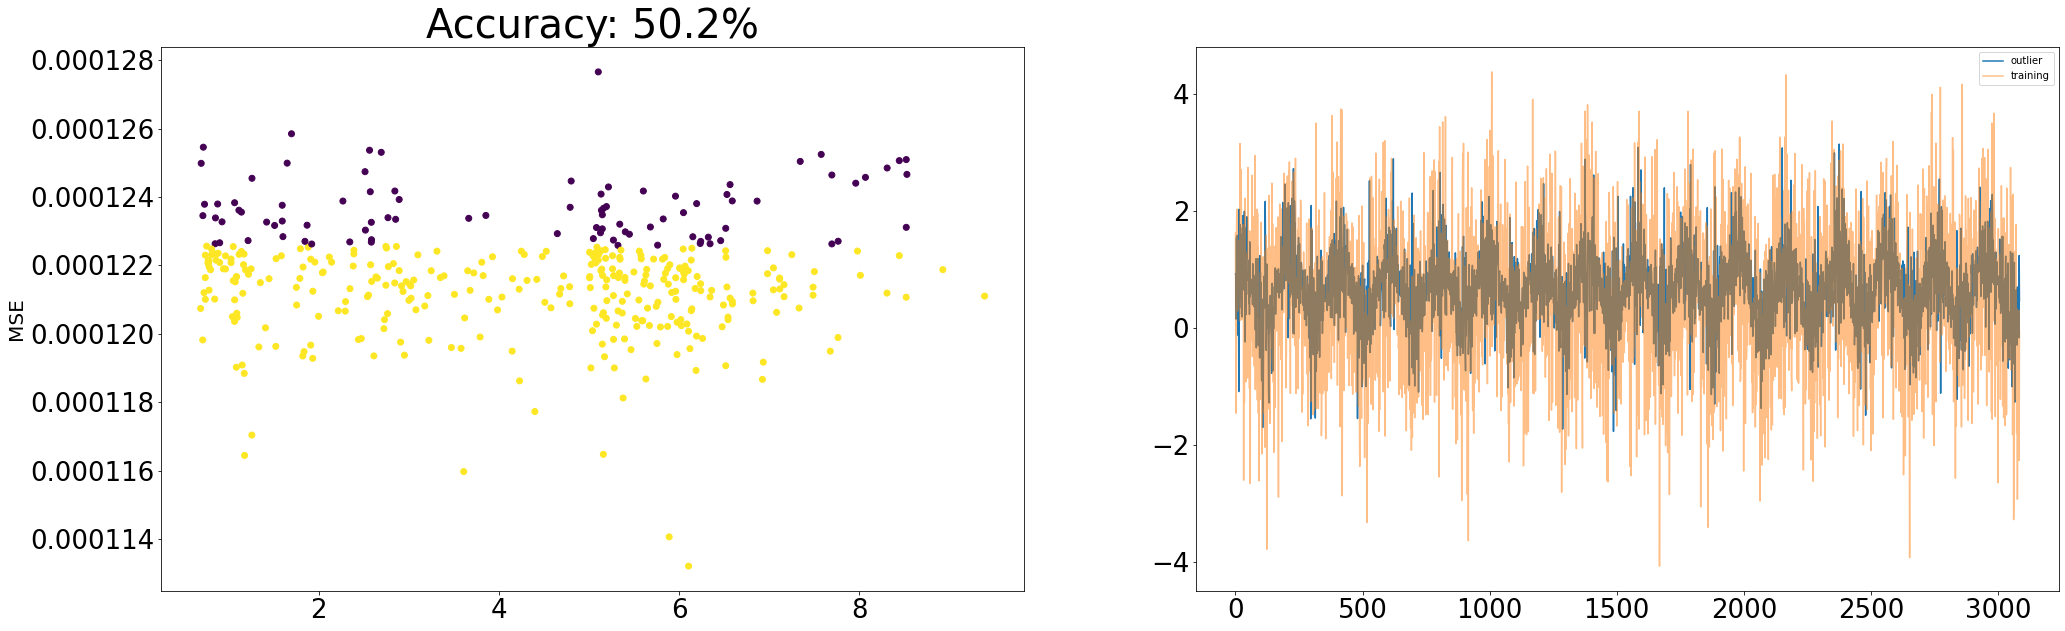

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(34,10))
limit = 400
ax1.scatter(df_loss_shuffle["IRI"][:limit],df_loss_shuffle['data'][:limit],c=predictions)
ax1.set_ylabel("MSE",fontsize=20)
ax1.set_title(f"Accuracy: {score*100:.1f}%",fontsize=40)
ax2.plot([np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]*np.sin(np.linspace(1,100,3085))+np.random.normal(loc=np.random.random(),scale=np.random.random(),size=3085)
,label="outlier")
ax2.plot([np.random.normal(loc=np.random.random(),scale=np.random.random()) for _ in range(3085)]*np.sin(np.linspace(1,100,3085))+np.random.normal(loc=np.random.random(),scale=np.random.random()*1.1,size=3085),label="training",alpha=0.5)
ax2.legend()

In [ ]:
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)
plt.figure(figsize=(18,12))
cnn_1 = np.where(predictions==0)[0]
cnn_2 = np.where(predictions==1)[0]
lstm_1 = np.where(predictions_a==0)[0]
lstm_2 = np.where(predictions_a==1)[0]
scaler_cnn = StandardScaler().fit(np.array(test_loss_log).reshape(-1,1))
scaler_lstm = StandardScaler().fit(np.array(test_loss_log_a).reshape(-1,1))
plt.scatter(np.linspace(0,600,300), np.array(test_loss_log)[0:300].reshape(-1,1),c="black",label="CNN Normal")
plt.scatter(np.linspace(0,600,300), np.array(test_loss_log)[300:].reshape(-1,1),c="b", label = "CNN Outlier")
plt.scatter(np.linspace(0,600,300), np.array(test_loss_log_a)[0:300].reshape(-1,1),c="y",label="LSTM Normal")
plt.scatter(np.linspace(0,600,300), np.array(test_loss_log_a)[300:].reshape(-1,1),c="g",label="LSTM Outlier")
plt.plot([0,600],[0.26,0.26],"r--",linewidth=4,label="SVC Decision Boundary")
plt.plot([0,600],[0.145,0.145],"r--",linewidth=4)
#plt.text(220,0.160,"SVC Decision Boundary CNN",fontsize=30,c="r")
plt.ylabel("MSE Loss",fontsize=30)
plt.title(f"Accuracy CNN: {score*100:.1f}% LSTM: {score_a*100:.1f}%",fontsize=40,pad=5)
plt.legend(fontsize=20,loc="center left",markerscale=2)

In [ ]:
def load_data():
  drive.mount('/content/drive')
  local_path = 'drive/MyDrive/Deep Learning/Lira/'
  #local_path = "C:/Users/simon/Nextcloud2/Master/Deep Learning/assignment/"
  data_path = local_path + "dataset_big_boi_new_no_split_no_shuffle.pickle"
  with open(data_path, "rb") as fh:
    dataset = pickle.load(fh)
  return dataset
dataset_train = load_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = load_data()
iri_cutoff =4.5
dataset = dataset.sample(frac=1,axis=0).reset_index(drop=True)
len_high_iri = np.where(dataset["IRI_mean"]>iri_cutoff)[0].shape[0]
len_low_iri = np.where(dataset["IRI_mean"]<iri_cutoff)[0].shape[0]
min_len = np.min([len_low_iri,len_high_iri])
print(min_len)
inds_high_iri_train = np.where(dataset["IRI_mean"]>iri_cutoff)[0][0:int(min_len*0.9)]
inds_high_iri_test = np.where(dataset["IRI_mean"]>iri_cutoff)[0][int(min_len*0.9):min_len]
inds_low_iri_train = np.where(dataset["IRI_mean"]<iri_cutoff)[0][0:int(min_len*0.9)]
inds_low_iri_test = np.where(dataset["IRI_mean"]<iri_cutoff)[0][int(min_len*0.9):min_len]
inds_test = np.concatenate((inds_high_iri_test,inds_low_iri_test))
inds_train = np.concatenate((inds_high_iri_train,inds_low_iri_train))
dataset_train = dataset[["z","IRI_mean"]].iloc[inds_train].reset_index(drop=True)
dataset_test = dataset[["z","IRI_mean"]].iloc[inds_test].reset_index(drop=True)

print(dataset_train)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
357
                                                     z  IRI_mean
0    [-0.40042180162900315, -0.9240201561204731, -0...  5.710033
1    [-0.49248072249739816, -0.2930625932658292, -0...  4.525818
2    [0.1519317235813644, 0.515207861339935, 0.5155...  5.717378
3    [-1.0471947328582398, -1.0138279844100027, -1....  5.890327
4    [0.33604956531815444, 0.3355922047608757, 0.33...  5.043121
..                                                 ...       ...
637  [0.1519317235813644, 0.15597654818181644, 0.15...  2.575062
638  [-0.49248072249739816, -0.47267824984488843, -...  1.962511
639  [-0.6765985642341882, -0.6522939064239477, -0....   4.29173
640  [-2.1519017832789746, -2.091521923884353, -1.6...  2.577772
641  [-0.2163039598922157, -0.2032547649763021, -0....  3.054048

[642 rows x 2 columns]


In [ ]:
t_log, v_log = [],[]
loss_cnn = []
epochs = 1
for epoch in range(epochs):
  train_loss = 0
  test_loss = 0
  model.train()
  batch_size = 1
  # dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)
  for idx in range(dataset_train.shape[0]//batch_size):
      batch = np.concatenate(dataset_train["z"].values[idx*batch_size:(idx+1)*batch_size]).reshape(-1,1,dataset_train["z"].values[0].shape[0])

      batch = torch.from_numpy(batch).to(device).float()
      output = model(batch)
      loss = loss_function(output, batch)
      loss_cnn.append(loss.cpu().detach().numpy())

[1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1
 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0
 0 1 1 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

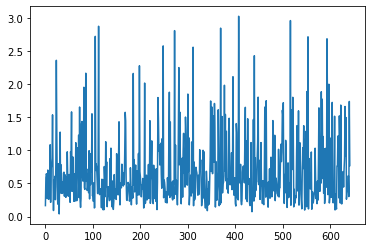

In [ ]:
plt.figure()
plt.plot(loss_cnn)
max_iri_value = 4.5

def fit_classifier(test_loss_log, y):

  clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5,max_iter=1e5))
  X = np.array(test_loss_log).reshape(-1,1)
  clf.fit(X, y)
  score = clf.score(X, y)
  preds = clf.predict(X)
  print(preds[:300])
  print(y[:300])
  print(f"Linear SVM accuracy: {score*100:.2f}%")
  print(preds)
  return score,preds

y = [0 if v<max_iri_value else 1 for v in dataset_train["IRI_mean"].values]

score_cnn, predictions_cnn = fit_classifier(loss_cnn,y)

In [ ]:
print(len(predictions_cnn))
print(len(dataset_train["IRI_mean"]))

3058
3058


Text(0.5, 1.0, 'Accuracy: 53.6%')

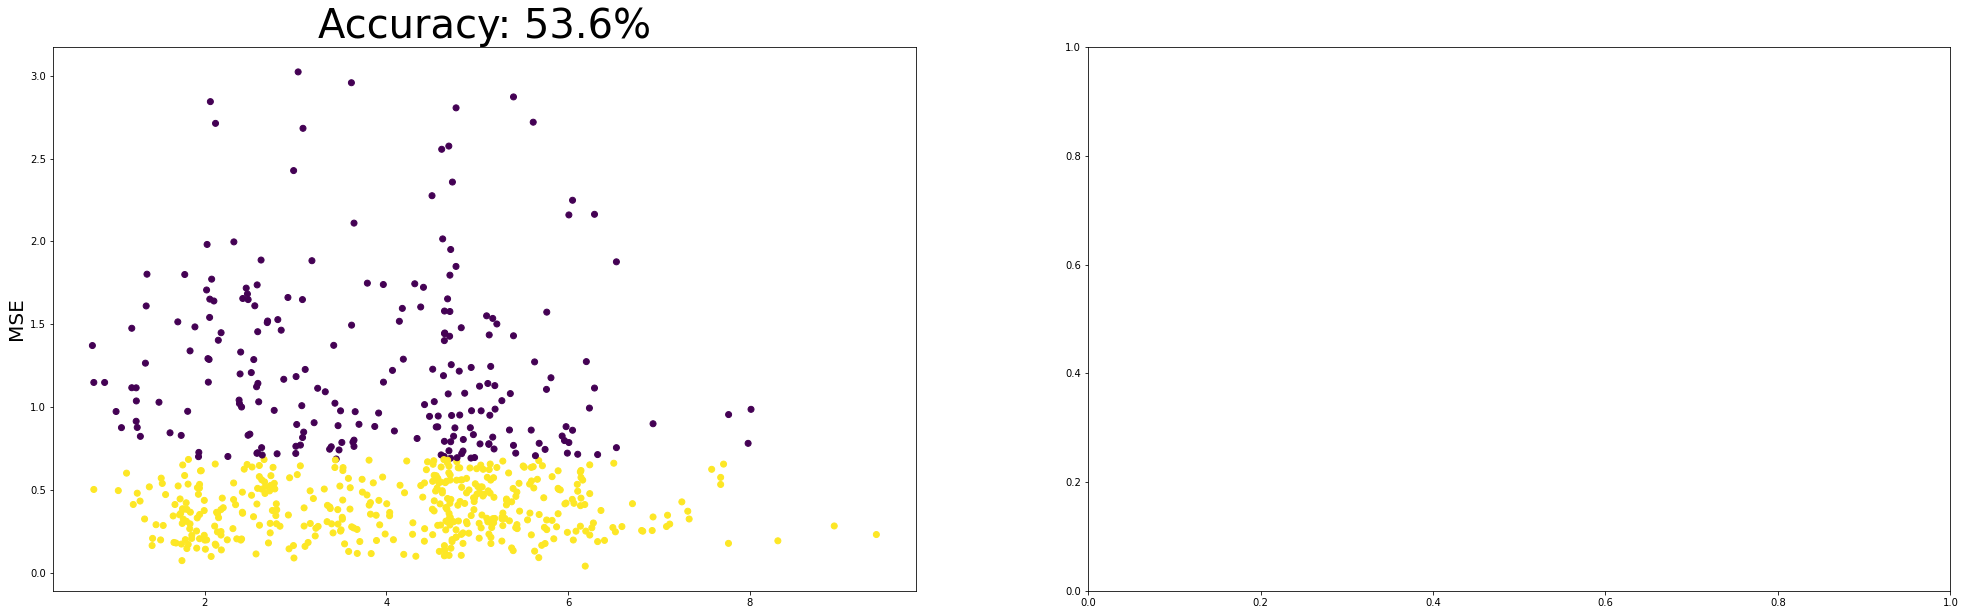

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(34,10))
limit = 400
ax1.scatter(dataset_train["IRI_mean"][:],loss_cnn[:],c=predictions_cnn[:])
ax1.set_ylabel("MSE",fontsize=20)
ax1.set_title(f"Accuracy: {score_cnn*100:.1f}%",fontsize=40)

In [ ]:
print(len(df_loss))
df_lstm = df_loss
df_lstm = df_lstm.sort_values(by=['IRI'])
bad = df_lstm.loc[df_lstm['IRI'] > 4.5]
good = df_lstm.loc[df_lstm['IRI'] < 4.5]
print(len(good))
print(len(bad))


712
329
383


178
642
329
329


<Figure size 1296x864 with 0 Axes>

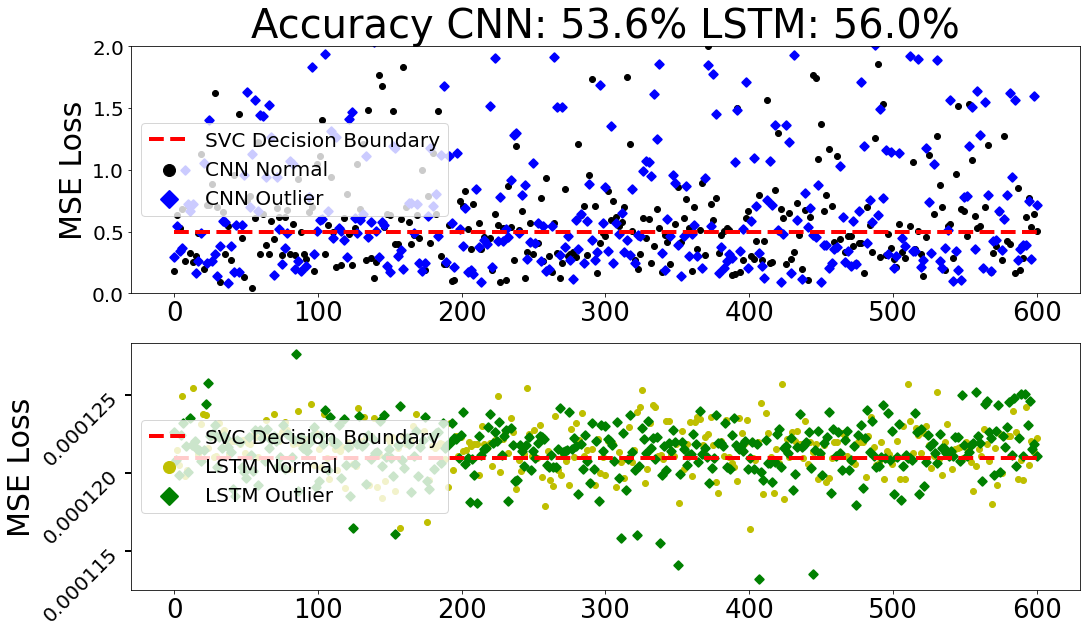

In [ ]:
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=20)
print(min_len//2)
print(len(loss_cnn))

plt.figure(figsize=(18,12))
cnn_1 = np.where(predictions==0)[0]
cnn_2 = np.where(predictions==1)[0]
# lstm_1 = np.where(predictions_a==0)[0]
# lstm_2 = np.where(predictions_a==1)[0]
cnn_11 = np.where(dataset_train["IRI_mean"]<4.5)
cnn_22 = np.where(dataset_train["IRI_mean"]>4.5)
scaler_cnn = StandardScaler().fit(np.array(loss_cnn).reshape(-1,1))
scaler_lstm = StandardScaler().fit(np.array(df_loss['data'].values).reshape(-1,1))

print(len(good))
bad_s = scaler_lstm.transform(np.array(df_lstm['data'].loc[df_lstm['IRI'] > 4.5].values).reshape(-1,1))
good_s = scaler_lstm.transform(np.array(df_lstm['data'].loc[df_lstm['IRI'] < 4.5].values).reshape(-1,1))
# loss_cnn_s = scaler_cnn.transform(np.array(loss_cnn).reshape(-1,1))

print(len(good_s))
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(17,10))
ax1.scatter(np.linspace(0,600,642//2), np.array(loss_cnn)[:642//2].reshape(-1,1),c="black",label="CNN Normal")
ax1.scatter(np.linspace(0,600,642//2), np.array(loss_cnn)[642//2:].reshape(-1,1),c="b", label = "CNN Outlier",marker="D",linewidth=2)
ax2.scatter(np.linspace(0,600,329), np.array(good['data']),c="y",label="LSTM Normal")
ax2.scatter(np.linspace(0,600,383), np.array(bad['data']),c="g",label="LSTM Outlier",marker="D",linewidth=2)
ax1.plot([0,600],[0.5,0.5],"r--",linewidth=4,label="SVC Decision Boundary")
ax2.plot([0,600],[0.000121,0.000121],"r--",linewidth=4,label="SVC Decision Boundary")
#plt.text(220,0.160,"SVC Decision Boundary CNN",fontsize=30,c="r")
ax1.set_ylabel("MSE Loss",fontsize=30)
ax2.set_ylabel("MSE Loss",fontsize=30)
ax1.set_ylim(0,2)
ax2.tick_params(axis='y',direction='out', length=6, width=2, colors='k',labelrotation =45,
               grid_color='r', grid_alpha=0.5)
ax1.set_title(f"Accuracy CNN: {score_cnn*100:.1f}% LSTM: {score*100:.1f}%",fontsize=40,pad=5)
ax1.legend(fontsize=20,loc="center left",markerscale=2)
ax2.legend(fontsize=20,loc="center left",markerscale=2)